# Partie 1 : Préparation des données

## 1. Collecte et prétraitement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
tweets = pd.read_csv('/content/drive/MyDrive/Deep Learning/stock_tweets.csv')

stock_data = pd.read_csv('/content/drive/MyDrive/Deep Learning/stock_yfinance_data.csv')

#Utilise seulement les données d'Amazon
tweets = tweets[tweets['Stock Name'] == 'AMZN']
stock_data = stock_data[stock_data['Stock Name'] == 'AMZN']


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # qui va diviser phrase en tokens

# Téléchargez la ressource 'punkt_tab'
nltk.download('punkt_tab')

#fctn de nettoyage des twwets
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = text.lower()
    text = word_tokenize(text) #appliquer tokenizer
    return " ".join(text)

tweets['cleaned_tweet'] = tweets['Tweet'].apply(clean_tweet) #appliquer fctn de nettoyage crée sur colone de Tweet

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
print(tweets[['Tweet', 'cleaned_tweet']].head())

                                                   Tweet  \
48351  A group of lawmakers led by Sen. Elizabeth War...   
48352  $NIO just because I'm down money doesn't mean ...   
48353  Today’s drop in $SPX is a perfect example of w...   
48354  Druckenmiller owned $CVNA this year \nMunger b...   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...   

                                           cleaned_tweet  
48351  a group of lawmakers led by sen elizabeth warr...  
48352  nio just because i m down money doesn t mean t...  
48353  today s drop in spx is a perfect example of wh...  
48354  druckenmiller owned cvna this year munger boug...  
48355  top 10 qqq holdings and credit rating aapl aaa...  


In [ ]:
from sklearn.preprocessing import MinMaxScaler
print(stock_data.head())
scaler = MinMaxScaler() #pour normalisation

stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.fit_transform(stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
print(stock_data.head())

            Date        Open        High         Low       Close   Adj Close  \
1008  2021-09-30  165.800003  166.392502  163.699493  164.251999  164.251999   
1009  2021-10-01  164.450500  165.458496  162.796997  164.162994  164.162994   
1010  2021-10-04  163.969498  163.999496  158.812500  159.488998  159.488998   
1011  2021-10-05  160.225006  163.036499  160.123001  161.050003  161.050003   
1012  2021-10-06  160.676498  163.216995  159.931000  163.100494  163.100494   

        Volume Stock Name  
1008  56848000       AMZN  
1009  56712000       AMZN  
1010  90462000       AMZN  
1011  65384000       AMZN  
1012  50660000       AMZN  
            Date      Open      High       Low     Close  Adj Close    Volume  \
1008  2021-09-30  0.760697  0.740026  0.756604  0.750876   0.750876  0.089039   
1009  2021-10-01  0.744415  0.728844  0.745668  0.749797   0.749797  0.088465   
1010  2021-10-04  0.738612  0.711376  0.697386  0.693138   0.693138  0.230925   
1011  2021-10-05  0.693435 

La normalisation est  essentielle pour améliorer la performance et la robustesse du modèle GAN, aussi qu'éliminer les problèmes liés aux valeurs très grandes ou très petites, évitant les erreurs d’optimisation.

## 2. Analyse de sentiments

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #outil d'anlyse de sentiment pour attribuer un score de sentiment à chaque tweet

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    vs = analyzer.polarity_scores(text) #attribuer un score de sentiment à chaque tweet.
    return vs['compound']

tweets['sentiment_score'] = tweets['cleaned_tweet'].apply(get_sentiment)
print(tweets[['cleaned_tweet', 'sentiment_score']].head())

                                           cleaned_tweet  sentiment_score
48351  a group of lawmakers led by sen elizabeth warr...           0.1027
48352  nio just because i m down money doesn t mean t...           0.2500
48353  today s drop in spx is a perfect example of wh...          -0.6197
48354  druckenmiller owned cvna this year munger boug...           0.2382
48355  top 10 qqq holdings and credit rating aapl aaa...           0.7783


In [ ]:
tweets['Date'] = pd.to_datetime(tweets['Date'])
tweets['Date'] = tweets['Date'].dt.date
tweets = tweets.drop(columns=['Tweet', 'Stock Name', 'Company Name'])
daily_sentiments = tweets.groupby(['Date'])[['sentiment_score']].mean()
print(daily_sentiments.head())


            sentiment_score
Date                       
2021-09-30         0.244260
2021-10-01         0.436450
2021-10-02         0.078867
2021-10-03         0.822500
2021-10-04         0.264467


Nous agrégeons les scores de sentiment pour réduire le bruit des tweets individuels et obtenir une tendance quotidienne plus fiable, alignée avec les données boursières. Cela simplifie l'analyse et améliore la précision des prédictions.

## 3. Visualisation des données

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

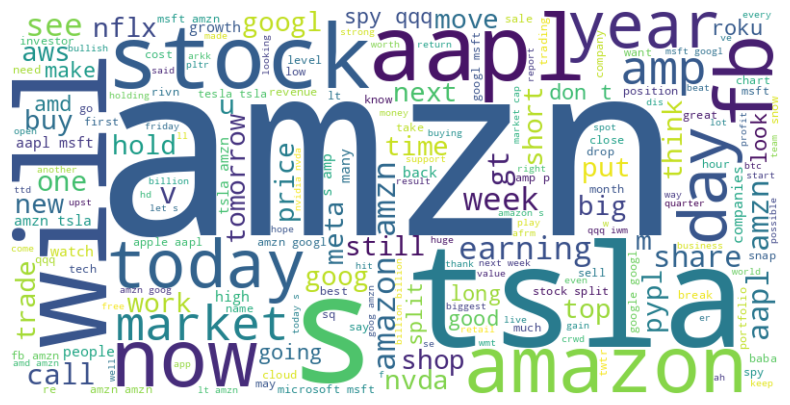

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(tweets['cleaned_tweet']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

D'après le contenu de l'image de nuage , on remarque que les mots les plus discutés sont:amazon , tsla ,  stock

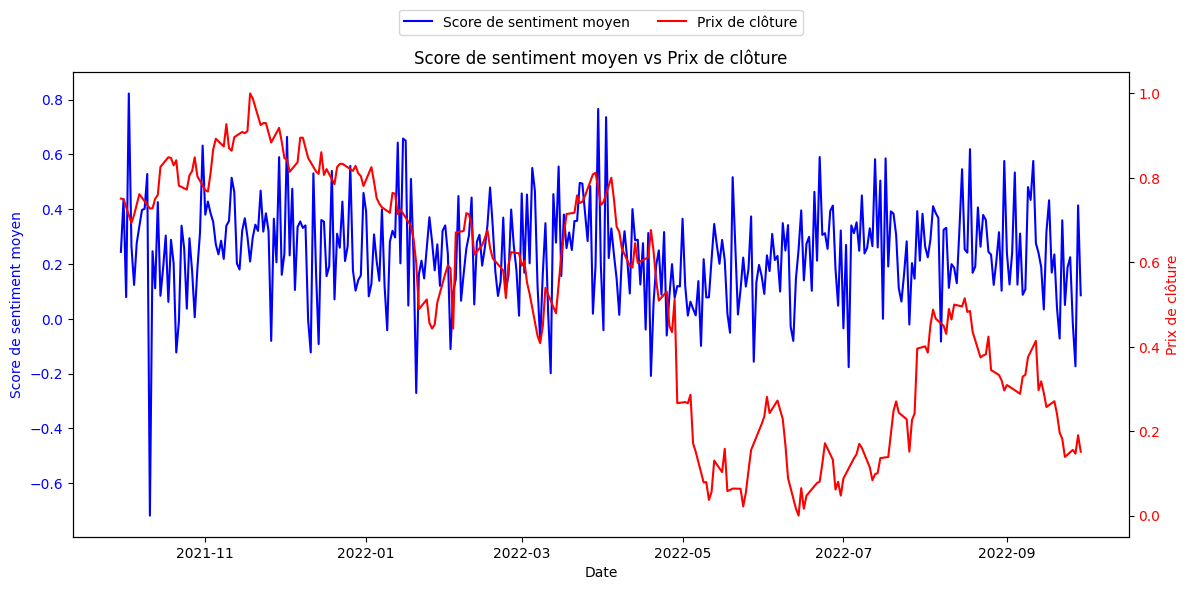

In [ ]:
daily_sentiments = daily_sentiments.reset_index()

daily_sentiments['Date'] = pd.to_datetime(daily_sentiments['Date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
daily_sentiments = daily_sentiments.sort_values(by='Date')
stock_data = stock_data.sort_values(by='Date')


fig, ax1 = plt.subplots(figsize=(12, 6))

line1, = ax1.plot(daily_sentiments['Date'], daily_sentiments['sentiment_score'],label='Score de sentiment moyen', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Score de sentiment moyen', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
line2, = ax2.plot(stock_data['Date'], stock_data['Close'],label='Prix de clôture', color='red')
ax2.set_ylabel('Prix de clôture', color='red')
ax2.tick_params(axis='y', labelcolor='red')
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.title('Score de sentiment moyen vs Prix de clôture')
plt.tight_layout()
plt.show()


On remarque qu'il y a une correlation entre le Prix de clôture et le Score de sentiment moyen, car quand le Score de sentiment moyen augmente, le Prix de clôture augmente aussi et vice versa.

# Partie 2 : Construction du modèle

## 4. Ajout d’indicateurs techniques

In [ ]:
#Jointure des données des tweets avec les données boursières.
final_data = stock_data.join(daily_sentiments.set_index('Date'), how="left", on="Date", lsuffix='_caller', rsuffix='_other')
final_data = final_data.drop(columns=['Stock Name'])

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() # Fermer la colonne
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() # Fermer la colonne

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #c'est la différence entre le prix de clôture et le prix d'ouverture

    # Créer des Bandes de Bollinger
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)


    return data

In [ ]:
final_data = get_tech_ind(final_data)
final_data = final_data.iloc[20:,:].reset_index(drop=True)
final_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band
0,2021-10-28,0.812637,0.830505,0.824468,0.848781,0.848781,0.331015,0.005518,0.813725,0.779518,0.001284,0.049838,0.879194,0.679842
1,2021-10-29,0.751057,0.768142,0.756198,0.803844,0.803844,0.396643,0.181812,0.810033,0.782220,0.008574,0.049606,0.881433,0.683007
2,2021-11-01,0.788326,0.768765,0.767528,0.770920,0.770920,0.153747,0.380155,0.799911,0.786109,0.006114,0.045099,0.876307,0.695911
3,2021-11-02,0.760100,0.741983,0.762396,0.767671,0.767671,0.070905,0.427871,0.797937,0.788890,0.007980,0.041894,0.872677,0.705102
4,2021-11-03,0.756474,0.780174,0.770860,0.810857,0.810857,0.135876,0.385514,0.803447,0.792587,0.013746,0.040298,0.873183,0.711991


Nous calculons ces indicateurs techniques pour identifier les tendances du marché, repérer les points d'entrée et de sortie potentiels, et améliorer la précision des prédictions en analysant les comportements passés des prix.

In [ ]:
# Convertit "Date" en datetime, trie et définit comme index.
final_data['Date'] = pd.to_datetime(final_data['Date'])
final_data = final_data.sort_values(by='Date').set_index('Date')


In [ ]:
X_final_data = final_data.drop(columns=['Close'])
y_final_data = final_data[['Close']]

## 5. Construction du modèle GAN

### Split des données

In [ ]:
import numpy as np
#  Divise les données d'entrée et de sortie en lots pour l'entraînement d'un modèle
def batch_data(x_data, y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0, len(x_data) - batch_size - predict_period + 1, 1):
        x_value = x_data.iloc[i : i + batch_size].values
        y_value = y_data.iloc[i + batch_size : i + batch_size + predict_period].values[:, 0]
        yc_value = y_data.iloc[i : i + batch_size].values
        X_batched.append(x_value)
        y_batched.append(y_value)
        yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [ ]:
# Divise les données en ensembles d'entraînement et de test
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
# Calcule les indices pour les prédictions de l'entraînement et du test.
def predict_index(dataset, X_train, batch_size, prediction_period):

    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
X_batched, y_batched, yc = batch_data(X_final_data, y_final_data, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(final_data, X_train, 5, 1)

X shape: (227, 5, 12)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

### Créer les modèles du GAN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, LeakyReLU, Dense



def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

Architecture du générateur :
Le générateur utilise des couches LSTM pour capturer les dépendances temporelles dans les données séquentielles. Il comprend :

1. 5 couches LSTM avec des unités allant de 1024 à 64, pour extraire progressivement des caractéristiques de plus en plus abstraites.
2. recurrent_dropout = 0.3 pour prévenir le sur-apprentissage.
3. Couches Dense (32, 16, 8 unités) à la fin pour affiner la sortie.

Architecture du discriminateur ;
Le discriminateur utilise des couches Conv1D pour extraire des caractéristiques locales des séries temporelles et une fonction d'activation LeakyReLU pour éviter le problème du vanishing gradient. Il comporte :

1. 5 couches Conv1D avec une augmentation progressive du nombre de filtres (8 à 128).
2. 2 couches Dense avec activation sigmoid à la sortie pour une classification binaire.

Pourquoi ce choix d'architecture ?
1. Générateur : Les LSTM sont bien adaptés pour les données temporelles, capturant des dépendances longues.
2. Discriminateur : Les CNN sont efficaces pour extraire des motifs locaux dans des séquences et classifier rapidement les données.
3. LeakyReLU et Dropout : Pour éviter le vanishing gradient et le sur-apprentissage

## 6. Entraînement du modèle

In [ ]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
@tf.function
#calcule les pertes du générateur et du discriminateur puis met à jour leurs poids via les gradients

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tqdm import tqdm
#entraîne les modèles générateur et discriminateur et calcule la RMSE à chaque époque
def train(real_x, real_y, yc, epochs, generator, discriminator, g_optimizer, d_optimizer):
    rmse_values = []

    for epoch in tqdm(range(epochs)):
        # Appeler train_step avec les optimiseurs et modèles préalablement créés
        real_price, fake_price, losses = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)

        # Accéder au dictionnaire des pertes pour obtenir d_loss et g_loss
        d_loss = losses['d_loss']
        g_loss = losses['g_loss']

        rmse = np.sqrt(mean_squared_error(real_price.numpy(), fake_price.numpy()))
        rmse_values.append(rmse)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}: D_loss={d_loss:.4f}, G_loss={g_loss:.4f}, RMSE={rmse:.4f}")

    return rmse_values

In [ ]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
RMSE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 10%|█         | 50/500 [02:18<16:19,  2.18s/it]

Epoch 50: D_loss=1.3347, G_loss=0.7215, RMSE=1.2688


 20%|██        | 100/500 [04:01<14:56,  2.24s/it]

Epoch 100: D_loss=1.3901, G_loss=0.6929, RMSE=0.1003


 30%|███       | 150/500 [05:42<11:20,  1.94s/it]

Epoch 150: D_loss=1.3855, G_loss=0.6951, RMSE=0.2085


 40%|████      | 200/500 [07:25<09:27,  1.89s/it]

Epoch 200: D_loss=1.3839, G_loss=0.6933, RMSE=0.0958


 50%|█████     | 250/500 [09:07<08:18,  2.00s/it]

Epoch 250: D_loss=1.2882, G_loss=0.7058, RMSE=0.5107


 60%|██████    | 300/500 [10:50<07:05,  2.13s/it]

Epoch 300: D_loss=1.4258, G_loss=0.8675, RMSE=0.1294


 70%|███████   | 350/500 [12:32<05:46,  2.31s/it]

Epoch 350: D_loss=1.3611, G_loss=0.7298, RMSE=0.0897


 80%|████████  | 400/500 [14:13<03:12,  1.92s/it]

Epoch 400: D_loss=1.3534, G_loss=0.7502, RMSE=0.0831


 90%|█████████ | 450/500 [15:55<01:34,  1.89s/it]

Epoch 450: D_loss=1.3707, G_loss=0.7190, RMSE=0.0816


100%|██████████| 500/500 [17:37<00:00,  2.12s/it]

Epoch 500: D_loss=1.3923, G_loss=0.6966, RMSE=0.0753


### l’évolution de la RMSE

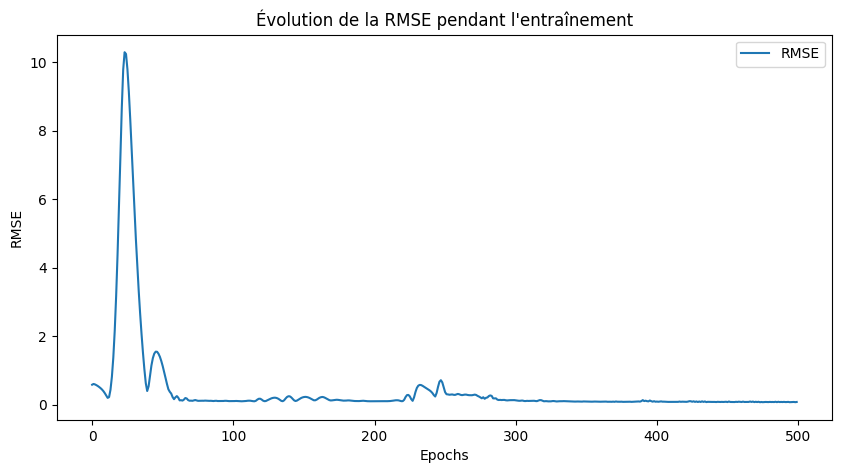

In [ ]:
def plot_rmse(rmse_values) :
  plt.figure(figsize=(10, 5))
  plt.plot(rmse_values, label='RMSE')
  plt.xlabel('Epochs')
  plt.ylabel('RMSE')
  plt.title("Évolution de la RMSE pendant l'entraînement")
  plt.legend()
  plt.show()

plot_rmse(RMSE)

Oui, le modèle semble converger. La courbe de RMSE diminue progressivement au fil des époques et se stabilise autour d'une valeur très basse après environ 100 époques.

# Partie 3 : Évaluation et analyse

## 7. Évaluation des performances

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


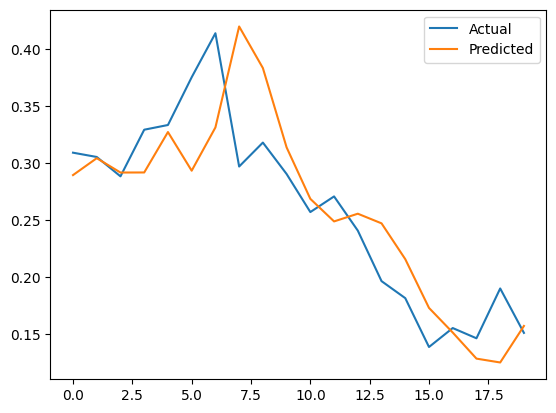

MSE: 0.00
MAE: 0.04
RMSE: 0.05


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate(generator, X_test, y_test):
    predictions = generator.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()

    print(f'MSE: {mse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')

evaluate(generator, X_test, y_test)

Le modèle GAN reproduit correctement les tendances principales et les pics des prix réels, mais présente des écarts dans les amplitudes et les variations fine, on peut dire que le modèle est partiellement efficace

## 8. Expérimentation avec un autre modèle (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train, n_estimators=100):
    # Redimensionner X_train en 2D avant d'entraîner le modèle
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train_reshaped, y_train)
    return model

trained_model = train_random_forest(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


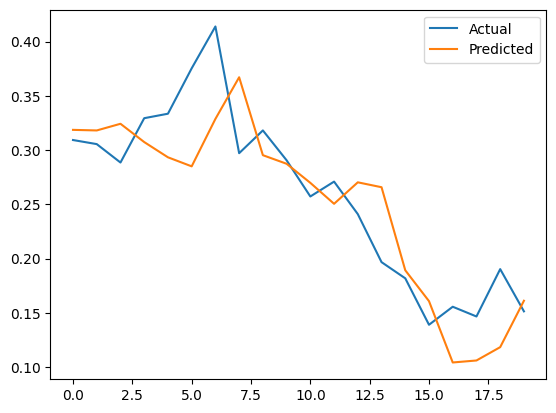

MSE: 0.00
MAE: 0.04
RMSE: 0.05


In [ ]:


evaluate(trained_model , X_test.reshape(X_test.shape[0] , -1) , y_test)

1. Comparaison par graphe : Le modèle GAN prédit des prix plus proches des prix réels par rapport au modèle Random Forest.
2. Comparaison par RMSE, MSE et MSA : Les valeurs de RMSE, MSE et MSA sont identiques pour les deux modèles, indiquant des performances similaires en termes d'erreurs globales.

## 9. Analyse critique

# **• Quelles sont les limites de l’utilisation des tweets pour prédire les cours boursiers ? Proposez des solutions pour améliorer la robustesse du modèle.**
## Limites de l'utilisation des tweets pour la prédiction boursière

L’analyse des tweets présente plusieurs défis : bruit et subjectivité, risque de manipulation, corrélation sans causalité, et latence des réactions du marché. Ces limites peuvent fausser les prédictions si elles ne sont pas correctement gérées.

## Améliorations possibles

Pour renforcer la robustesse du modèle, il est essentiel d’intégrer un filtrage avancé des tweets, des sources de données complémentaires, la détection des bots, et l’apprentissage en temps réel afin d’adapter les prédictions aux tendances du marché.

# **• Discutez des implications éthiques de l’utilisation de l’IA pour prédire les marchés financiers. Quels sont les risques potentiels ?**

## Implications éthiques et risques

L'usage de l'IA en finance pose des défis comme l’inégalité d’accès aux technologies, les risques de manipulation des marchés, l’amplification des bulles spéculatives, et les biais algorithmiques.

## Mesures d’atténuation

Pour une utilisation responsable, il est crucial de rendre les modèles transparents, mettre en place une régulation adaptée, et former les investisseurs aux limites des prédictions basées sur l’IA.
